# Introduction
New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona.

With it's diverse culture , comes diverse food items. There are many resturants in New york City, each beloning to different categories like Chinese , Indian , French etc.

So as part of this project , we will list and visualize all major parts of New York City that has great indian resturants.

# Data
Data For this project we need the following data :

New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. Data source : https://cocl.us/new_york_dataset Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city. Indian resturants in each neighborhood of new york city. Data source : Fousquare API Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only indian resturants. GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

# Approach
Collect the new york city data from https://cocl.us/new_york_dataset
Using FourSquare API we will find all venues for each neighborhood.
Filter out all venues that are Indian Resturants.
Find rating , tips and like count for each Indian Resturants using FourSquare API.
Using rating for each resturant , we will sort that data.
Visualize the Ranking of neighborhoods using folium library(python)
## Queries that can be answered using above dataset
What is best location in New York City for Indian Cuisine ?
Which areas have potential Indian Resturant Market ?
Which all areas lack Indian Resturants ?
Which is the best place to stay if I prefer Indian Cuisine ?
## Analysis
### Required Libraries
pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [6]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [7]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


In [8]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'HAC54E3LCQKVNPSE3A3SFDORD31PEEMMC42J3QYT4HZNR3W2' # changed my Foursquare ID
    CLIENT_SECRET = '1QHTHUVBMCPB53DWG1BIJOFOHSRQGUMWPKQFMQZXYLTGS00R' # changed Foursquare Secret
    VERSION = '20200513' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [9]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'HAC54E3LCQKVNPSE3A3SFDORD31PEEMMC42J3QYT4HZNR3W2' # i have changed the id with ##
    CLIENT_SECRET = '1QHTHUVBMCPB53DWG1BIJOFOHSRQGUMWPKQFMQZXYLTGS00R' # i have changed the secret with ##
    VERSION = '20200513' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [10]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [11]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [12]:
new_york_data.shape

(306, 4)

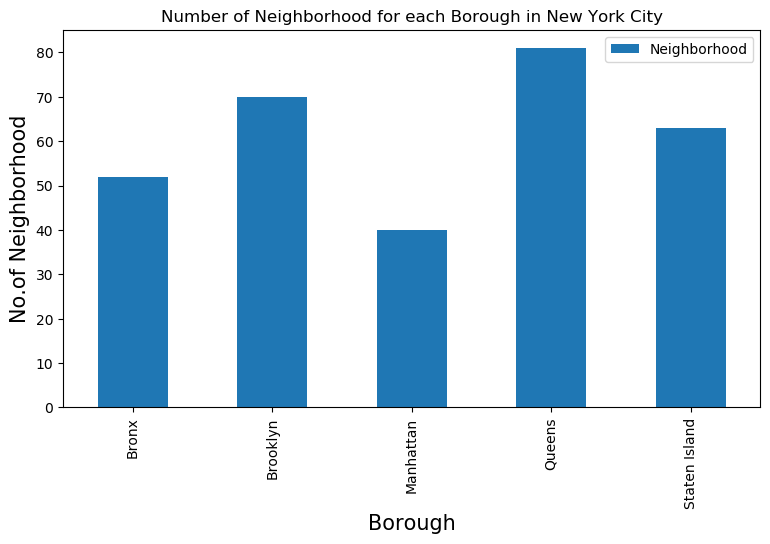

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [14]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Resturants in Ford

done
( 132 / 306 ) Indian Resturants in Jackson Heights, Queens:5
done
( 133 / 306 ) Indian Resturants in Elmhurst, Queens:4
done
( 134 / 306 ) Indian Resturants in Howard Beach, Queens:0
done
( 135 / 306 ) Indian Resturants in Corona, Queens:0
done
( 136 / 306 ) Indian Resturants in Forest Hills, Queens:0
done
( 137 / 306 ) Indian Resturants in Kew Gardens, Queens:2
done
( 138 / 306 ) Indian Resturants in Richmond Hill, Queens:7
done
( 139 / 306 ) Indian Resturants in Flushing, Queens:0
done
( 140 / 306 ) Indian Resturants in Long Island City, Queens:3
done
( 141 / 306 ) Indian Resturants in Sunnyside, Queens:1
done
( 142 / 306 ) Indian Resturants in East Elmhurst, Queens:0
done
( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
done
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
done
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
done
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
done
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
done
( 148 / 306 ) 

done
( 259 / 306 ) Indian Resturants in Elm Park, Staten Island:0
done
( 260 / 306 ) Indian Resturants in Remsen Village, Brooklyn:0
done
( 261 / 306 ) Indian Resturants in New Lots, Brooklyn:0
done
( 262 / 306 ) Indian Resturants in Paerdegat Basin, Brooklyn:0
done
( 263 / 306 ) Indian Resturants in Mill Basin, Brooklyn:0
done
( 264 / 306 ) Indian Resturants in Jamaica Hills, Queens:4
done
( 265 / 306 ) Indian Resturants in Utopia, Queens:0
done
( 266 / 306 ) Indian Resturants in Pomonok, Queens:0
done
( 267 / 306 ) Indian Resturants in Astoria Heights, Queens:1
done
( 268 / 306 ) Indian Resturants in Claremont Village, Bronx:0
done
( 269 / 306 ) Indian Resturants in Concourse Village, Bronx:1
done
( 270 / 306 ) Indian Resturants in Mount Eden, Bronx:0
done
( 271 / 306 ) Indian Resturants in Mount Hope, Bronx:0
done
( 272 / 306 ) Indian Resturants in Sutton Place, Manhattan:1
done
( 273 / 306 ) Indian Resturants in Hunters Point, Queens:0
done
( 274 / 306 ) Indian Resturants in Turtle

In [15]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [16]:
indian_rest_ny.shape

(145, 4)

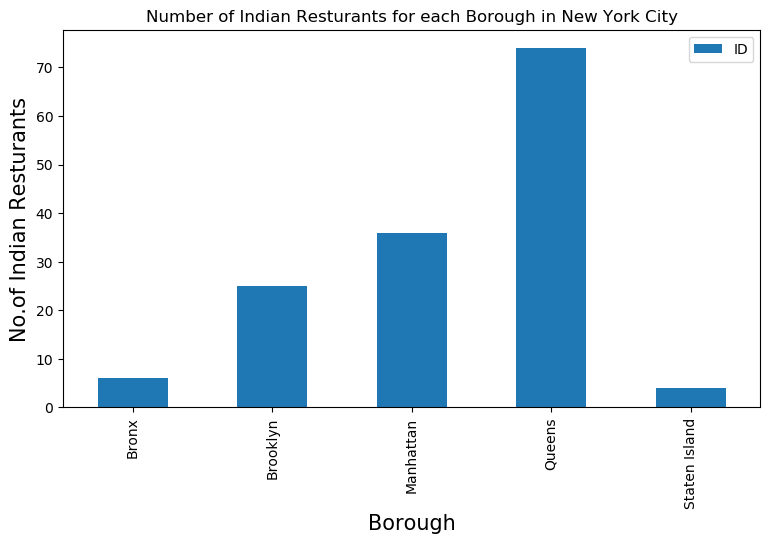

In [17]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

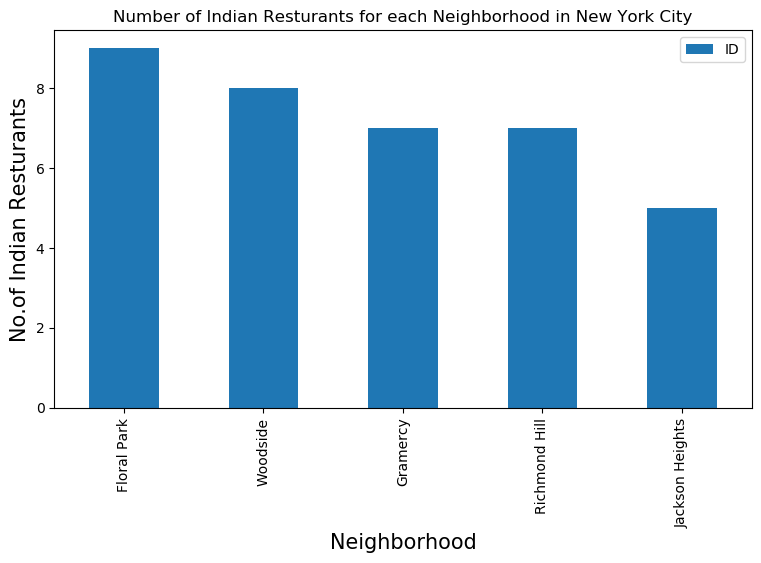

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [19]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
103,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
104,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
105,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
106,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
107,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
108,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
109,Queens,Floral Park,4cc642ed306e224b5bf2a76c,Shahi Darbar
110,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
111,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [20]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.8    10
( 1 / 145 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 2 / 145 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     6.0     9
( 3 / 145 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     6.8     3
( 4 / 145 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.0     2
( 5 / 145 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     38     8.0    26
( 6 / 145 ) processed
                         ID          Name  Likes

KeyError: 'venue'

In [21]:
indian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [22]:
indian_rest_stats_ny.shape

(40, 7)

In [23]:
indian_rest_ny.shape

(145, 4)

In [24]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [25]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [26]:
indian_rest_stats_ny_csv.shape

(40, 7)

In [27]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.8,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,6.0,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,6.8,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.0,2


In [28]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       40 non-null     object 
 1   Neighborhood  40 non-null     object 
 2   ID            40 non-null     object 
 3   Name          40 non-null     object 
 4   Likes         40 non-null     object 
 5   Rating        40 non-null     float64
 6   Tips          40 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.3+ KB


In [29]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [30]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [31]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       40 non-null     object 
 1   Neighborhood  40 non-null     object 
 2   ID            40 non-null     object 
 3   Name          40 non-null     object 
 4   Likes         40 non-null     float64
 5   Rating        40 non-null     float64
 6   Tips          40 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.3+ KB


In [32]:
# Resturant with maximum Likes
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                   Yorkville
ID              5272ca4511d22488f6895caf
Name                      Drunken Munkey
Likes                                208
Rating                               8.4
Tips                                  61
Name: 33, dtype: object

In [33]:
# Resturant with maximum Rating
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Fort Greene
ID              57596dad498e732300496b23
Name                         Dosa Royale
Likes                                 75
Rating                               8.8
Tips                                  22
Name: 15, dtype: object

In [34]:
# Resturant with maximum Tips
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood            Roosevelt Island
ID              4fe4fb50c2eee335e4fea69d
Name                    Moti Mahal Delux
Likes                                186
Rating                               8.5
Tips                                  83
Name: 35, dtype: object

In [35]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [36]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
3,Clinton Hill,8.8
9,Fort Greene,8.8
20,Prospect Lefferts Gardens,8.7
19,Prospect Heights,8.7
16,Murray Hill,8.6
26,Upper West Side,8.5
22,Roosevelt Island,8.5
23,South Side,8.4
6,East Flatbush,8.3
29,Yorkville,8.2


In [37]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [38]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,7.993333
1,Brooklyn,7.865000
0,Bronx,6.520000


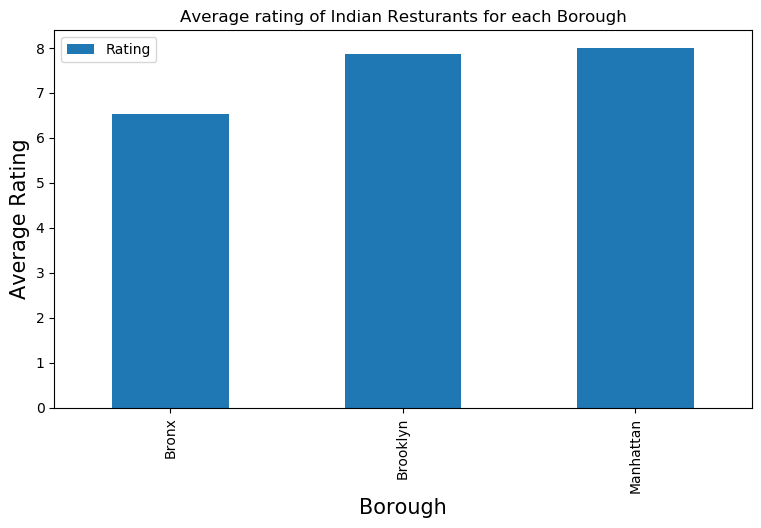

In [39]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [40]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [41]:
ny_neighborhood_stats

,Neighborhood,Average Rating


In [42]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [43]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [44]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating


In [45]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [46]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [47]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [48]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

# Conclusion
Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.
Manhattan have potential Indian Resturant Market
Staten Island ranks last in average rating of Indian Resturants.
Manhattan is the best place to stay if you prefer Indian Cuisine.
Limitations
The ranking is purely on basis of rating of resturants
The accuracy of data depends purely depends on the data provided by FourSquare

### Limitations

The ranking is purely on basis of rating of resturants
The accuracy of data depends purely depends on the data provided by FourSquare